<a href="https://colab.research.google.com/github/vitamingyu/NLP-LLM/blob/main/tf_54dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# GAN 모델 구현 : CIFAR10 dataset - color image
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

In [9]:
# generator
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)  # UpSampling2D와 유사한 기능
# 생성자에서 픽셀공간을 균일하게 다루지 못해 가끔 체스판 모양이 나타나는데 이를 방지하는 효과
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
print(generator.summary())

# discriminator
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input,x)
print(discriminator.summary())

discriminator.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005, clipvalue=1.0), loss='binary_crossentropy')
# clipvalue = 기울기 값 자르기. 기울기 폭주 방지용(임계값을 넘지 못하도록 함). 학습이 안정적으로 진행
# decay = 학습진행시 점차 학습률을 줄임. 학습이 안정적으로 진행

# GAN모델(적대적 네트워크) 구성
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0003, clipvalue=1.0), loss='binary_crossentropy')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_11 (Dense)            (None, 32768)             1081344   
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_6 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 32, 32, 256)       104

1/1 [==============================] - 0s 16ms/step
step 100에서 판별자 손실 : 0.6947816610336304
step 100에서 적대적 손실 : 0.8475310206413269
1/1 [==============================] - 0s 31ms/step
step 200에서 판별자 손실 : 0.6904652118682861
step 200에서 적대적 손실 : 0.7843365669250488
1/1 [==============================] - 0s 18ms/step
step 300에서 판별자 손실 : 0.6724262237548828
step 300에서 적대적 손실 : 0.7519169449806213
1/1 [==============================] - 0s 17ms/step
step 400에서 판별자 손실 : 0.6711611747741699
step 400에서 적대적 손실 : 0.8421863317489624
1/1 [==============================] - 0s 17ms/step
step 500에서 판별자 손실 : 0.694853663444519
step 500에서 적대적 손실 : 0.7872179746627808
1/1 [==============================] - 0s 18ms/step
step 600에서 판별자 손실 : 0.6874359250068665
step 600에서 적대적 손실 : 0.8229519128799438
1/1 [==============================] - 0s 17ms/step
step 700에서 판별자 손실 : 0.7199505567550659
step 700에서 적대적 손실 : 0.8339630961418152
1/1 [==============================] - 0s 18ms/step
step 800에서 판별자 손실 : 0.6826621890068054


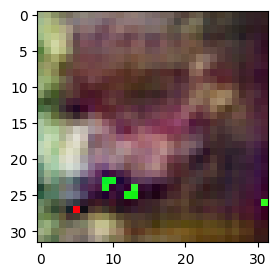

In [15]:
# train
import os
if not os.path.exists('./gan_images'):
  os.mkdir('./gan_images')

from keras.preprocessing import image
from keras.datasets import cifar10
(x_train, y_train), (_, _) = cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]  # 6번째 클래스 (개구리 이미지)
# print(x_train[0], y_train[0])

x_train = x_train.reshape((x_train.shape[0], ) + (height, width, channels)).astype('float32') / 255
# print(x_train)

iterations = 1000  # 1000
batch_size = 20

start = 0
for step in range(1, iterations):
  random_latent_vec = np.random.normal(size = (batch_size, latent_dim))  # 무작위 샘플링
  generated_images = generator.predict(random_latent_vec)  # 가짜 이미지 디코딩

  stop = start + batch_size
  real_images = x_train[start:stop]

  # 진짜 이미지와 연결
  combine_images = np.concatenate([generated_images, real_images])

  # 진짜, 가짜 이미지를 구분해 레이블 합치기
  labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

  labels += np.random.random(labels.shape) * 0.05  # 레이블에 랜덤 노이즈를 추가

  d_loss = discriminator.train_on_batch(combine_images, labels)

  random_latent_vector = np.random.normal(size=(batch_size, latent_dim))

  misleading_target = np.zeros((batch_size, 1))  # 모두 가짜이미지 라고 레이블을 만듦
  g_loss = gan.train_on_batch(random_latent_vec, misleading_target)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('tf54gan.h5')  # 모델 가중치 저장
    print('step %s에서 판별자 손실 : %s'%(step, d_loss))
    print('step %s에서 적대적 손실 : %s'%(step, g_loss))

    # 생성 이미지 저장
    img = image.array_to_img(generated_images[0] * 255., scale = False)
    img.save('./gan_images/frog' + str(step) + '.png')

    # 비교를 위해 진짜 이미지 하나를 저장
    img = image.array_to_img(real_images[0] * 255., scale=False)
    img.save('./gan_images/real_frog' + str(step) + '.png')

import matplotlib.pyplot as plt
random_latent_vec = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vec)
plt.figure(figsize=(3, 3))

for i in range(generated_images.shape[0]):
  img = image.array_to_img(generated_images[i] * 255., scale=False)
  plt.imshow(img)

plt.show()